In [2]:
import os
import time
import io
import base64
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
image_path = 'tests/kreml.png'
model = tf.saved_model.load('./model/')

In [3]:
def preprocess_image(image_path):
    #hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    hr_image = np.asarray(image_path)
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save("%s.jpg" % filename)
    print("Saved as %s.jpg" % filename)

In [4]:
%matplotlib inline
def plot_image(image, title=""):

  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

def scale_image(image, scale):
    """Scales down images using bicubic downsampling."""
    image_size = [image.shape[1], image.shape[0]]  # width, height
    image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))
    
    lr_image = np.asarray(
        Image.fromarray(image.numpy())
        .resize([int(image_size[0] * scale), int(image_size[1] * scale)], Image.Resampling.BICUBIC)
    )
    
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

131 130 3


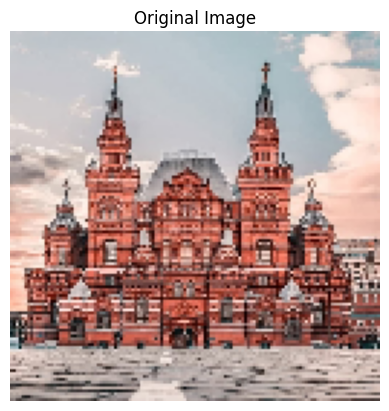

In [6]:
img = Image.open(image_path)
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_bytes = file.read()
Hi, Wi, channels = img.shape
print(Hi, Wi, channels)
fata = img
#plt.imshow(img)
img = preprocess_image(img)
plot_image(tf.squeeze(img), title="Original Image")
#save_image(tf.squeeze(hr_image), filename="Original Image")


2024-12-23 05:19:00.277894: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.


Time Taken: 4.890335


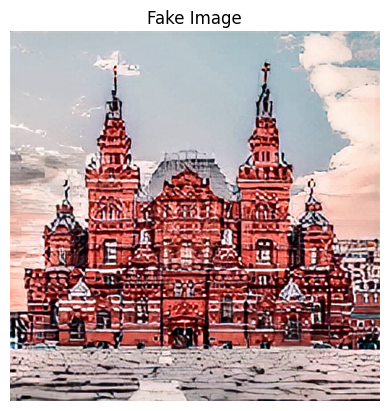

In [7]:
start = time.time()
fake_image = model(img)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))
plot_image(tf.squeeze(fake_image), title="Fake Image")
#save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [8]:
# Function to downscale the image using bicubic downsampling
def downscale_image(image):
    """Scales down images using bicubic downsampling."""
    image_size = [image.shape[1], image.shape[0]]  # width, height
    image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))
    
    lr_image = np.asarray(
        Image.fromarray(image.numpy())
        .resize([image_size[0] // 4, image_size[1] // 4], Image.BICUBIC)
    )
    
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

# Function to evaluate the performance of the super-resolved image using PSNR
def evaluate_performance(hr_image, sr_image):
    # Ensure both images have the same shape before calculating PSNR
    sr_image_resized = tf.image.resize(sr_image, size=hr_image.shape[1:3], method='bicubic')
    
    # Calculate PSNR between the original and super-resolved image
    psnr_value = tf.image.psnr(
        tf.clip_by_value(sr_image_resized, 0, 255),
        tf.clip_by_value(hr_image, 0, 255), max_val=255
    )
    print("PSNR Achieved: %f" % psnr_value)
    return psnr_value

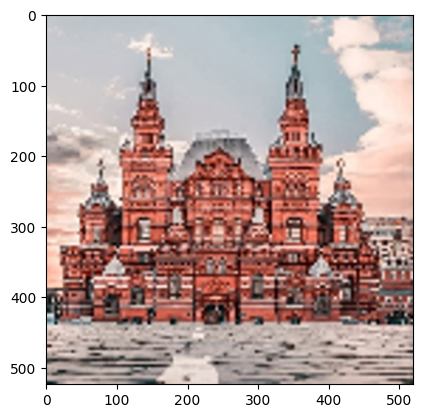

In [9]:
# #smoothed_img = cv2.imread(image_path, 0)
#smoothed_img = cv2.cvtColor(tf.cast(fata, tf.float32).numpy(), 0)
# #smoothed_img = downscale_image(tf.squeeze(fake_image))
# #Hi, Wi, channels = smoothed_img.shape
# print(Hi, Wi, channels)
# high_res_img = cv2.resize(smoothed_img, (Wi * 4, Hi * 4), interpolation=cv2.INTER_CUBIC)
# plt.imshow(high_res_img)

smoothed_img = scale_image(fata, 4)
smoothed_img = tf.squeeze(smoothed_img)
smoothed_img = tf.clip_by_value(smoothed_img, 0, 255)
smoothed_img = Image.fromarray(tf.cast(smoothed_img, tf.uint8).numpy())
plt.imshow(smoothed_img)
plt.show()
#plot_image(tf.squeeze(smoothed_img), title="Shrinked Image")

In [21]:
import argparse
import io
from PIL import Image
import time
import cv2
import base64
import numpy as np
import tensorflow as tf
from flask import Flask, render_template, request, redirect, send_file

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

sr_image = None
scaled_image = None
to_save = None

app = Flask(__name__)

def preprocess_image(image):
    #hr_image = tf.image.decode_image(image)
    hr_image = np.asarray(image)
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def serve_pil_image(pil_img):
    img_io = io.BytesIO()
    pil_img.save(img_io, 'png', quality=100)
    img_io.seek(0)
    img = base64.b64encode(img_io.getvalue()).decode('ascii')
    img_tag = f'<img src="data:image/png;base64,{img}" class="img-fluid" style="height:500px;"/>'
    return img_tag

def scale_image(image, scale):
    """Scales down images using bicubic downsampling."""
    image_size = [image.shape[1], image.shape[0]]  # width, height
    image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))
    
    lr_image = np.asarray(
        Image.fromarray(image.numpy())
        .resize([int(image_size[0] * scale), int(image_size[1] * scale)], Image.Resampling.BICUBIC)
    )
    
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

@app.route('/download_image')
def download_file():
    temp = io.BytesIO()
    to_save.save(temp, format="png")
    temp.seek(0)
    return send_file(temp, download_name="SR_Image.png", as_attachment=True)

@app.route("/", methods=["GET", "POST"])
def predict():
    global sr_image
    global scaled_image
    global to_save
    timeS = ''
    max_h = 500
    if request.method == "POST":
        if "file" not in request.files:
            return render_template("index.html", sr_image=sr_image, scaled_image=scaled_image)
        file = request.files["file"]
        if not file:
            return render_template("index.html", sr_image=sr_image, scaled_image=scaled_image)

        img_bytes = file.read()
        file_bytes = np.asarray(bytearray(img_bytes), dtype=np.uint8)
        img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lr_image = preprocess_image(img)

        start = time.time()
        sr_image = model(lr_image)
        sr_image = tf.squeeze(sr_image)
        timeS = str(round(time.time() - start, 2))

        scaled_image = scale_image(img, 4)
        scaled_image = tf.squeeze(scaled_image)
        scaled_image = tf.clip_by_value(scaled_image, 0, 255)
        scaled_image = Image.fromarray(tf.cast(scaled_image, tf.uint8).numpy())
        scaled_image = serve_pil_image(scaled_image)

        if not isinstance(sr_image, Image.Image):
            sr_image = tf.clip_by_value(sr_image, 0, 255)
            sr_image = Image.fromarray(tf.cast(sr_image, tf.uint8).numpy())
            to_save = sr_image
        sr_image = serve_pil_image(sr_image)
    return render_template("index.html", sr_image=sr_image, scaled_image=scaled_image, message=timeS)


model = tf.saved_model.load('./model/')
app.run(host="0.0.0.0", port=5000)  # debug=True causes Restarting with stat


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.26.140.49:5000
Press CTRL+C to quit
127.0.0.1 - - [23/Dec/2024 04:55:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Dec/2024 04:55:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Dec/2024 04:55:15] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [23/Dec/2024 04:55:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Dec/2024 04:55:23] "GET /download_image HTTP/1.1" 200 -
